#### I will find more data and update soon.

In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import os
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(123)

In [4]:
#No module named 'numba.decorators'
#conda install -c numba numba
#conda install -c conda-forge librosa

#cannot load library libsndfile64bit.dll 
#pip uninstall soundfile
#pip install soundfile

In [2]:
import librosa
import os

audio_dir = 'Respiratory_Sound_Database/audio_and_txt_files'
wav_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]

min_duration = float('inf')
for wav_file in wav_files:
    samples, sample_rate = librosa.load(wav_file)
    duration = librosa.get_duration(y=samples, sr=sample_rate)
    if duration < min_duration:
        min_duration = duration

print('Minimum duration:', min_duration, 'seconds')


Minimum duration: 7.8560090702947845 seconds


In [5]:
audio_dir = 'Respiratory_Sound_Database/audio_and_txt_files'
wav_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]

In [6]:
directory = audio_dir
count = 0

for file in os.listdir(directory):
    if file.endswith(".wav"):
        count += 1

print(f"Number of .wav files in directory: {count}")

Number of .wav files in directory: 920


In [7]:
n_mels = 128
max_sec = 6

all_mel_spec = []
for wav_file in wav_files:
    samples, sample_rate = librosa.load(wav_file, duration=max_sec)
    mel_spec = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    all_mel_spec.append(log_mel_spec)

X_train = np.array(all_mel_spec)
X_train = np.expand_dims(X_train, axis=-1)

X_train.shape

(920, 128, 259, 1)

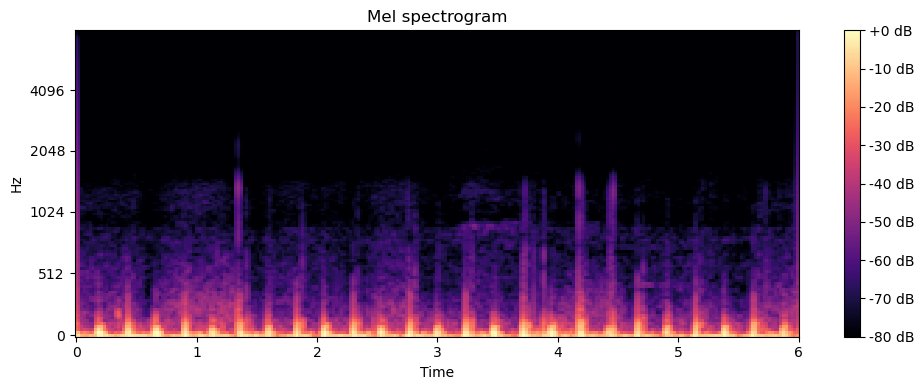

In [31]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(all_mel_spec[0], y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [9]:
y_train = pd.read_csv("Respiratory_Sound_Database/patient_diagnosis.csv" ,  header=None)
y_train = y_train.rename(columns={0: "id", 1: "type"})
# y_train.loc[y_train['type'] != 'Healthy', 'type'] = 'Unhealthy'
y_train

,id,type
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [10]:
y_train["type"].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: type, dtype: int64

In [11]:
patient_ids = [int(f.split("_")[0]) for f in os.listdir(audio_dir) if f.endswith(".wav")]
new_y_train = pd.DataFrame({'id': patient_ids})
for i, pid in enumerate(patient_ids):
    match = y_train['id'] == pid
    if match.any():
        new_y_train.at[i, 'type'] = y_train[match]['type'].values[0]
    else:
        new_y_train.at[i, 'type'] = 'Unknown'
new_y_train

,id,type
0,101,URTI
1,101,URTI
2,102,Healthy
3,103,Asthma
4,104,COPD
...,...,...
915,224,Healthy
916,225,Healthy
917,226,Pneumonia
918,226,Pneumonia


In [12]:
new_y_train["type"].value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: type, dtype: int64

In [13]:
y_train = new_y_train
# y_train["type"] = np.where(y_train["type"] == "Healthy", 0, 1)
y_train['type'].replace({'COPD': 0, 'Pneumonia': 1, 'Healthy': 2 , 'URTI':3 , 'Bronchiectasis':4 , 'Bronchiolitis':5 ,'LRTI':6 , 'Asthma':7}, inplace=True)
y_train = y_train.drop("id", axis=1)
y_train = to_categorical(y_train, 8)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
def apply_spec_augment(spectrogram, num_masks=2, freq_mask_length=27, time_mask_length=100):
    for i in range(num_masks):
        f = np.random.randint(low=0, high=spectrogram.shape[0] - freq_mask_length)
        spectrogram[f:f+freq_mask_length, :] = 0

    for i in range(num_masks):
        t = np.random.randint(low=0, high=spectrogram.shape[1] - time_mask_length)
        spectrogram[:, t:t+time_mask_length] = 0

    return spectrogram

In [15]:
X_train_aug = []
y_train_aug = []

for i in range(X_train.shape[0]):
    spectrogram = X_train[i, :, :, 0]
    for j in range(10):
        augmented_spectrogram = apply_spec_augment(spectrogram)
        X_train_aug.append(augmented_spectrogram[:, :, np.newaxis])
        y_train_aug.append(y_train[i])

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print("Original X_train shape:", X_train.shape)
print("Augmented X_train shape:", X_train_aug.shape)
print("Original y_train shape:", y_train.shape)
print("Augmented y_train shape:", y_train_aug.shape)

Original X_train shape: (920, 128, 259, 1)
Augmented X_train shape: (9200, 128, 259, 1)
Original y_train shape: (920, 8)
Augmented y_train shape: (9200, 8)


In [16]:
X_train = X_train_aug
y_train = y_train_aug

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)
X_train.shape , y_train.shape , X_val.shape, y_val.shape , X_test.shape, y_test.shape

((6256, 128, 259, 1),
 (6256, 8),
 (1104, 128, 259, 1),
 (1104, 8),
 (1840, 128, 259, 1),
 (1840, 8))

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report , confusion_matrix ,ConfusionMatrixDisplay

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 60s 301ms/step - loss: 0.5826 - accuracy: 0.8692 - val_loss: 0.3185 - val_accuracy: 0.9004
Epoch 2/10
196/196 [==============================] - 60s 305ms/step - loss: 0.2885 - accuracy: 0.9137 - val_loss: 0.2389 - val_accuracy: 0.9149
Epoch 3/10
196/196 [==============================] - 59s 299ms/step - loss: 0.1973 - accuracy: 0.9369 - val_loss: 0.1483 - val_accuracy: 0.9583
Epoch 4/10
196/196 [==============================] - 60s 306ms/step - loss: 0.1601 - accuracy: 0.9509 - val_loss: 0.1163 - val_accuracy: 0.9674
Epoch 5/10
196/196 [==============================] - 59s 302ms/step - loss: 0.1338 - accuracy: 0.9581 - val_loss: 0.0880 - val_accuracy: 0.9810
Epoch 6/10
196/196 [==============================] - 53s 273ms/step - loss: 0.1145 - accuracy: 0.9668 - val_loss: 0.0816 - val_accuracy: 0.9783
Epoch 7/10
196/196 [==============================] - 60s 304ms/step - loss: 0.1132 - accuracy: 0.9652 - val_loss: 0.0736 - val_ac

In [25]:
score = model.evaluate(X_test,y_test)
print("accuracy : " + str(score[1] * 100) )

58/58 [==============================] - 4s 73ms/step - loss: 0.0624 - accuracy: 0.9832
accuracy : 98.31521511077881


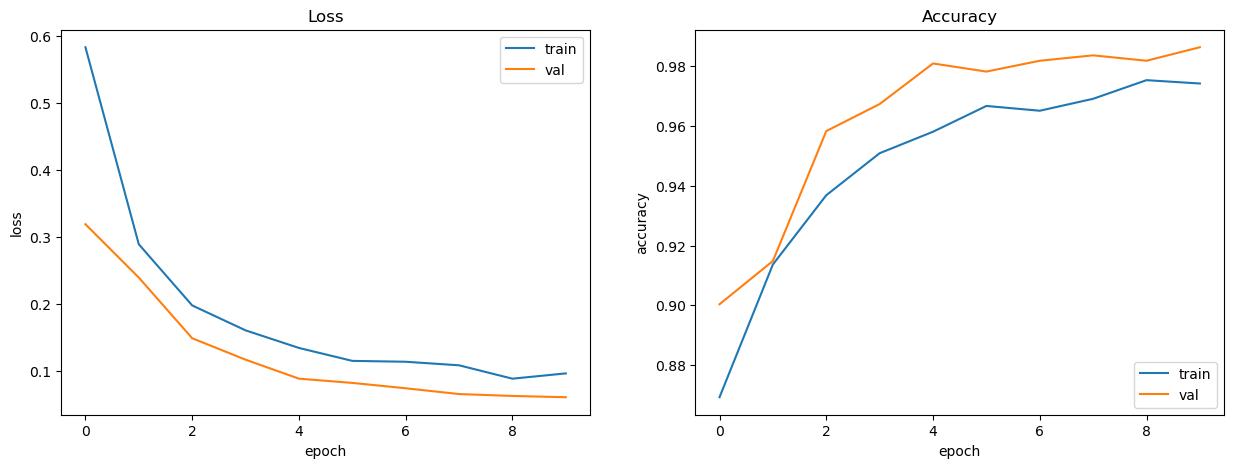

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(15,5))

ax1.set_title('Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'val'], loc='upper right')


ax2.set_title('Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'val'], loc='lower right')

58/58 [==============================] - 4s 68ms/step


[Text(0.5, 0, 'Predictions'), Text(0, 0.5, 'Actuals')]

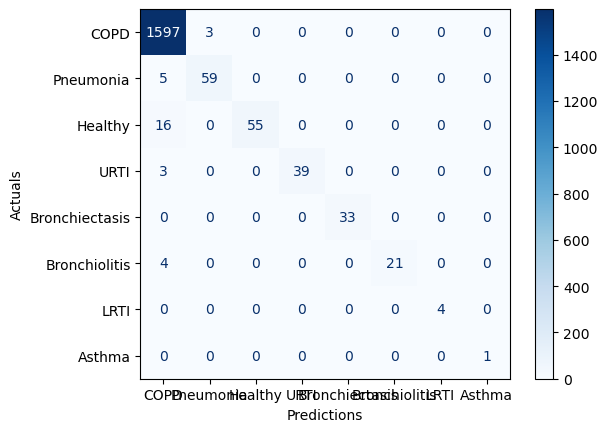

In [28]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_true, y_pred_classes) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['COPD', 'Pneumonia', 'Healthy' , 'URTI' , 'Bronchiectasis' , 'Bronchiolitis' ,'LRTI' , 'Asthma'])
disp.plot(cmap='Blues')
disp.ax_.set(xlabel='Predictions', ylabel='Actuals')

In [29]:
print(classification_report(y_true , y_pred_classes, target_names=['COPD', 'Pneumonia', 'Healthy' , 'URTI' , 'Bronchiectasis' , 'Bronchiolitis' ,'LRTI' , 'Asthma']))

                precision    recall  f1-score   support

          COPD       0.98      1.00      0.99      1600
     Pneumonia       0.95      0.92      0.94        64
       Healthy       1.00      0.77      0.87        71
          URTI       1.00      0.93      0.96        42
Bronchiectasis       1.00      1.00      1.00        33
 Bronchiolitis       1.00      0.84      0.91        25
          LRTI       1.00      1.00      1.00         4
        Asthma       1.00      1.00      1.00         1

      accuracy                           0.98      1840
     macro avg       0.99      0.93      0.96      1840
  weighted avg       0.98      0.98      0.98      1840

